## Reference
[deploy_sam_on_sagemaker.ipynb](https://github.com/Napkin-DL/image-segmentation-with-bedrock-rekognition/blob/main/SageMaker/1.%20deploy_sam_on_sagemaker.ipynb)


In [1]:
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
sagemaker.__version__

'2.214.3'

In [3]:
%load_ext autoreload
%autoreload 2

## 0. Prepare Your Model

In [4]:
!sudo rm -rf ./model

In [5]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./model

--2024-04-10 01:15:26--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.230.61.127, 54.230.61.48, 54.230.61.126, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.230.61.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘./model/sam_vit_h_4b8939.pth’

100%[====================================>] 2,564,550,879  237MB/s   in 11s    

2024-04-10 01:15:37 (229 MB/s) - ‘./model/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [6]:
import boto3
import sagemaker
import json

sess = sagemaker.Session()
sm_session = sagemaker.session.Session()
boto_session = boto3.session.Session()
sm_client = boto3.client("sagemaker")
bucket = sm_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto_session.region_name

print((bucket, role))

('sagemaker-ap-northeast-2-533267442321', 'arn:aws:iam::533267442321:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole')


## 1. Create Model Serving Script

In [7]:
!cd model && sudo rm -rf /code && mkdir code

In [8]:
%%writefile model/code/requirements.txt
git+https://github.com/facebookresearch/segment-anything.git

Writing model/code/requirements.txt


In [9]:
%%writefile model/code/inference.py
import json
import base64
import numpy as np
from io import BytesIO
from PIL import Image
from segment_anything import SamPredictor, sam_model_registry

def _encode(image):
    img = image
    img_byte_arr = BytesIO()
    img.save(img_byte_arr, format="PNG")
    img_byte_arr = img_byte_arr.getvalue()
    img_byte_arr = base64.b64encode(img_byte_arr).decode()
    return img_byte_arr


def _decode(image):
    image = base64.b64decode(image)
    image = Image.open(BytesIO(image))
    return image


def model_fn(model_dir):
    """
    Deserialize and return fitted model.
    """
    print("--------------- model_fn Start ---------------")
    sam = sam_model_registry["vit_h"](checkpoint=model_dir + "/sam_vit_h_4b8939.pth")
    sam.to(device='cuda')
    
    predictor = SamPredictor(sam)
    print("--------------- model_fn End ---------------")
    return predictor
                     

def input_fn(data, request_content_type):
    """
    The SageMaker XGBoost model server receives the request data body and the content type,
    and invokes the `input_fn`.
    Return a DMatrix (an object that can be passed to predict_fn).
    """
    print("Content type: ", request_content_type)
    if request_content_type == "application/json":        
        input_data = json.loads(data)
        face_image = _decode(input_data["encode_image"])
        numpy_image = np.array(face_image)
        input_box = np.array(input_data["input_box"])
        return (numpy_image, input_box)
    else:
        raise ValueError(
            "Content type {} is not supported.".format(request_content_type)
        )
        

def predict_fn(input_data, predictor):
    """
    SageMaker model server invokes `predict_fn` on the return value of `input_fn`.
    Return a two-dimensional NumPy array (predictions and scores)
    """
    
    numpy_image = input_data[0]
    input_box = input_data[1]
    input_label = np.array([0])
    
    predictor.set_image(numpy_image)
    masks, _, _ = predictor.predict(box=input_box,
                                    point_labels=input_label,
                                    multimask_output=False)
    
    return masks


def output_fn(masks, content_type="application/json"):
    """
    After invoking predict_fn, the model server invokes `output_fn`.
    """
    mask = (np.array(masks[0])) * 255.0
    mask = 255 - mask
    mask_img = Image.fromarray(mask)
    mask_img = mask_img.convert('RGB')    
    
    image_final = _encode(mask_img)

    return json.dumps({"mask_image": image_final})

Writing model/code/inference.py


## 2. Deploy a trained model from Amazon S3

In [10]:
prefix = 'sam/deploy'
s3_model_path = f's3://{bucket}/{prefix}/model.tar.gz'
!cd model && tar -czvf model.tar.gz sam_vit_h_4b8939.pth ./code && mv model.tar.gz ../
!aws s3 cp model.tar.gz {s3_model_path}
!rm -rf model.tar.gz

sam_vit_h_4b8939.pth
./code/
./code/requirements.txt
./code/inference.py
upload: ./model.tar.gz to s3://sagemaker-ap-northeast-2-533267442321/sam/deploy/model.tar.gz


In [11]:
# ecr_image_uri = '763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.1.0-gpu-py310-cu118-ubuntu20.04-sagemaker'
ecr_image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch', 
    version='2.1.0',
    instance_type='ml.g4dn.2xlarge',
    region=region, 
    image_scope='inference'
)

In [22]:
import base64
import boto3
import copy
from PIL import Image
from io import BytesIO


import os
import numpy as np
import matplotlib.pyplot as plt


from botocore.config import Config

def encode_image(image, formats="PNG"):
    buffer = BytesIO()
    image.save(buffer, format=formats)
    img_str = base64.b64encode(buffer.getvalue())
    return img_str


def decode_image(img):
    img = img.encode("utf8") if type(img) == "bytes" else img
    buff = BytesIO(base64.b64decode(img))
    image = Image.open(buff)
    return image


def label_list():
    import pandas as pd
    pd.set_option('display.max_columns', 150)
    pd.set_option('display.max_colwidth', None)
    
    ## 모델 별 label list : https://docs.aws.amazon.com/rekognition/latest/dg/labels.html
    label_path = 'AmazonRekognitionBoundingBoxLabels_v3.0.csv'

    csv_file = pd.read_csv(label_path)
    label_lists = list(csv_file['Label'].values)
    
    label_table = {}
    label_cnt = {}
    max_cnt = 0
    for label_item in label_lists:
        start_char = label_item[0]
        # print(start_char)
        if label_table.get(start_char):
            label_table[start_char].append(label_item)
            label_cnt[start_char] += 1
            if max_cnt < label_cnt[start_char]:
                max_cnt = label_cnt[start_char]
        else:
            label_table[start_char] = [label_item]
            label_cnt[start_char] = 1

    for start_char in label_cnt:
        iter_cnt = max_cnt - label_cnt[start_char]
        for _ in range(iter_cnt):
            label_table[start_char].append('-')

    return pd.DataFrame(label_table)


def boto3_runtime(service_name, target_region):
    session_kwargs = {"region_name": target_region}
    client_kwargs = {**session_kwargs}

    retry_config = Config(
        region_name=target_region,
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )

    session = boto3.Session(**session_kwargs)

    boto3_runtime = session.client(
        service_name=service_name,
        config=retry_config,
        **client_kwargs
    )
    
    return boto3_runtime


def show_faces(img_path, target_region='us-west-2'):
    client = boto3_runtime(
        service_name='rekognition',
        target_region=target_region
    )

    image = Image.open(img_path).convert('RGB')
    image = img_resize(image)

    buffer = BytesIO()
    image.save(buffer, format='jpeg', quality=100)
    val = buffer.getvalue()

    response = client.detect_faces(Image={'Bytes': val},Attributes=['ALL'])

    imgWidth, imgHeight = image.size       
    ori_image = copy.deepcopy(image)

    for faceDetail in response['FaceDetails']:
        print('The detected face is between ' + str(faceDetail['AgeRange']['Low']) 
              + ' and ' + str(faceDetail['AgeRange']['High']) + ' years old')

        box = faceDetail['BoundingBox']
        left = imgWidth * box['Left']
        top = imgHeight * box['Top']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']

        print(f"imgWidth : {imgWidth}, imgHeight : {imgHeight}")
        print('Left: ' + '{0:.0f}'.format(left))
        print('Top: ' + '{0:.0f}'.format(top))
        print('Face Width: ' + "{0:.0f}".format(width))
        print('Face Height: ' + "{0:.0f}".format(height))

    return ori_image, imgWidth, imgHeight, int(left), int(top), int(width), int(height), response


def show_labels(img_path, target_label=None, target_region='us-west-2'):
    client = boto3_runtime(
        service_name='rekognition',
        target_region=target_region
    )
    
    if target_label is None:
        Settings = {"GeneralLabels": {"LabelInclusionFilters":[]},"ImageProperties": {"MaxDominantColors":1}}
        # print(f"target_label_None : {target_label}")
    else:
        Settings = {"GeneralLabels": {"LabelInclusionFilters":[target_label]},"ImageProperties": {"MaxDominantColors":1}}
        # print(f"target_label : {target_label}")
    
    box = None
    
    image = Image.open(img_path).convert('RGB')
    image = img_resize(image)

    buffer = BytesIO()
    image.save(buffer, format='jpeg', quality=100)
    val = buffer.getvalue()
    
    response = client.detect_labels(Image={'Bytes': val},
                                    MaxLabels=15,
                                    MinConfidence=0.7,
                                    # Uncomment to use image properties and filtration settings
                                    Features=["GENERAL_LABELS", "IMAGE_PROPERTIES"],
                                    Settings=Settings
                                   )

    imgWidth, imgHeight = image.size       
    ori_image = copy.deepcopy(image)
    color = 'white'

    for item in response['Labels']:
        # print(item)
        if len(item['Instances']) > 0:
            print(item)
            print(item['Name'], item['Confidence'])

            for sub_item in item['Instances']:
                color = sub_item['DominantColors'][0]['CSSColor']
                box = sub_item['BoundingBox']
                break
        break
    try:
        left = imgWidth * box['Left']
        top = imgHeight * box['Top']
        width = imgWidth * box['Width']
        height = imgHeight * box['Height']

        print(f"imgWidth : {imgWidth}, imgHeight : {imgHeight}")
        print('Left: ' + '{0:.0f}'.format(left))
        print('Top: ' + '{0:.0f}'.format(top))
        print('Object Width: ' + "{0:.0f}".format(width))
        print('Object Height: ' + "{0:.0f}".format(height))
        return ori_image, imgWidth, imgHeight, int(left), int(top), int(width), int(height), color, response
    except:
        print("There is no target label in the image.")
        return _, _, _, _, _, _, _, _, _


def boto3_runtime(service_name, target_region=boto3.Session().region_name):
    session_kwargs = {"region_name": target_region}
    client_kwargs = {**session_kwargs}

    retry_config = Config(
        region_name=target_region,
        retries={
            "max_attempts": 10,
            "mode": "standard",
        },
    )

    session = boto3.Session(**session_kwargs)

    boto3_runtime = session.client(
        service_name=service_name,
        config=retry_config,
        **client_kwargs
    )
    
    return boto3_runtime


def img_resize(image):
    imgWidth, imgHeight = image.size 
    
    max_length =  512  

    if imgWidth < imgHeight:
        imgWidth = int(max_length/imgHeight*imgWidth)
        imgWidth = imgWidth-imgWidth%64
        imgHeight = max_length
    else:
        imgHeight = int(max_length/imgWidth*imgHeight)
        imgHeight = imgHeight-imgHeight%64
        imgWidth = max_length 

    image = image.resize((imgWidth, imgHeight), resample=0)
    return image


def image_to_base64(img) -> str:
    """Converts a PIL Image or local image file path to a base64 string"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        buffer = BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")

## 2.1. Deploy to Local Environment: Model class


In [13]:
instance_type='local_gpu'

In [14]:
from pathlib import Path
import time

# source_dir=f"file://{Path.cwd()}/src"

if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    from sagemaker.local import entities
    # entities.HEALTH_CHECK_TIMEOUT_LIMIT=300  
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    
    model_data_url=f"file://{Path.cwd()}/model"
    model_data=f"file://{Path.cwd()}/model.tar.gz"
else:
    sagemaker_session = sagemaker.session.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data_url=s3_model_path
    
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"sam-model-{ts}"
endpoint_config_name = f"sam-endpoint-config-{ts}"
endpoint_name = f"sam-endpoint-{ts}"

In [15]:
local_container = {
   "Image": ecr_image_uri,
   "ModelDataUrl" : model_data_url,
   "ModelDataSource": {
           "S3DataSource": {
               "S3Uri": model_data_url,
               "S3DataType": "S3Prefix",
               "CompressionType": "None",  ## local
           },
       },
   "Environment": {}
}

In [16]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=local_container
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            "ContainerStartupHealthCheckTimeoutInSeconds": 3600,
        }
    ],
)

In [17]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [18]:
# !docker kill 6f6a5ef17e66

In [19]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



Login Succeeded
Attaching to 4th8ly3egt-algo-1-uoxg5
4th8ly3egt-algo-1-uoxg5  | Collecting git+https://github.com/facebookresearch/segment-anything.git (from -r /opt/ml/model/code/requirements.txt (line 1))
4th8ly3egt-algo-1-uoxg5  |   Cloning https://github.com/facebookresearch/segment-anything.git to /home/model-server/tmp/pip-req-build-ll4fs8nk
4th8ly3egt-algo-1-uoxg5  |   Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /home/model-server/tmp/pip-req-build-ll4fs8nk
4th8ly3egt-algo-1-uoxg5  |   Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
4th8ly3egt-algo-1-uoxg5  |   Preparing metadata (setup.py) ... done
4th8ly3egt-algo-1-uoxg5  | Building wheels for collected packages: segment-anything
4th8ly3egt-algo-1-uoxg5  |   Building wheel for segment-anything (setup.py) ... done
4th8ly3egt-algo-1-uoxg5  |   Created wheel for segment-anything: filename=segment_

In [20]:
!docker ps

CONTAINER ID   IMAGE                                                                                 COMMAND                  CREATED              STATUS              PORTS                                                 NAMES
759c066a3415   763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/pytorch-inference:2.1.0-gpu-py310   "python /usr/local/b…"   About a minute ago   Up About a minute   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp, 8081/tcp   4th8ly3egt-algo-1-uoxg5


In [23]:
label_list()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,Z
0,Adult,Baby,Camera,Dagger,E-scooter,Face,Gas Pump,Hammer,Ice Cream,Jacket,Kangaroo,Lamp,Mace Club,Necklace,Orange,Package,QR Code,Rat,Sandal,T-Shirt,Utility Pole,Vest,Wallet,Zebra
1,Airplane,Backpack,Can,Desk,Earbuds,Female,Gate,Handbag,Ice Hockey Puck,Jeans,Kayak,Laptop,Mailbox,Notebook,Overcoat,Painting,-,Razor,Sandwich,Tablet Computer,-,Violin,Washer,-
2,Altar,Balloon,Candle,Diamond,Earring,Field Hockey Stick,Giant Panda,Handcuffs,Ice Hockey Stick,-,Ketchup,Lawn Mower,Male,-,-,Pajamas,-,Refrigerator,Scarf,Tank,-,Volleyball (Ball),Wedding Cake,-
3,American Football (Ball),Banana,Canoe,Diaper,Egg,Fire Hydrant,Giraffe,Hanukkah Menorah,Id Cards,-,Kitchen Island,License Plate,Man,-,-,Panther,-,Remote Control,Scissors,Tape,-,VR Headset,Wedding Gown,-
4,Antelope,Baseball (Ball),Car,Dining Table,Elephant,Fire Truck,Girl,Hardhat,Insect,-,Knife,Lifejacket,Microphone,-,-,Pants,-,Ring,Scoreboard,Tattoo,-,-,Wheel,-
5,Apple,Baseball Bat,Cat,Dinosaur,-,Fireplace,Glasses,Hat,-,-,-,Lighthouse,Microwave,-,-,Passport,-,Road Sign,Screw,Teddy Bear,-,-,White Board,-
6,Arrow,Baseball Cap,Ceiling Fan,Disk,-,First Aid,Glove,Head,-,-,-,Limo,Milk,-,-,Pear,-,Rocket,Screwdriver,Teen,-,-,Windmill,-
7,Axe,Baseball Glove,Chair,Disposable Cup,-,Fish,Grenade,Headphones,-,-,-,Lion,Mixer,-,-,Pen,-,Rose,Shaker,Tennis Ball,-,-,Woman,-
8,-,Basketball (Ball),Chandelier,Document,-,Flag,Guitar,Helicopter,-,-,-,Lipstick,Mobile Phone,-,-,Penguin,-,Rug,Shark,Tennis Racket,-,-,Wristwatch,-
9,-,Bathtub,Cheetah,Dog,-,Flyer,Gun,Helmet,-,-,-,Lizard,Monitor,-,-,Perfume,-,Rugby Ball,Sheep,Tent,-,-,-,-


In [24]:
img_path = f'andy_portrait_2.jpg' ## 원하는 이미지를 선택합니다.
target_label = None
# target_label="Car"

In [26]:
ext = img_path.split('.')[-1]
if ext == 'jpg':
    ext = 'jpeg'

## [주의] add policy for this:
AccessDeniedException: An error occurred (AccessDeniedException) when calling the DetectFaces operation: User: arn:aws:sts::533267442321:assumed-role/AmazonSageMakerServiceCatalogProductsUseRole/SageMaker is not authorized to perform: rekognition:DetectFaces because no identity-based policy allows the rekognition:DetectFaces action

In [30]:
%%time

if target_label == None:
    object_image, width, height, f_left, f_top, f_width, f_height, human_res = show_faces(img_path) ## detect_faces
else:
    object_image, width, height, f_left, f_top, f_width, f_height, color, human_res = show_labels(img_path, target_label=target_label)

The detected face is between 53 and 61 years old
imgWidth : 512, imgHeight : 256
Left: 212
Top: 41
Face Width: 92
Face Height: 126
CPU times: user 68.9 ms, sys: 19.6 ms, total: 88.5 ms
Wall time: 1.73 s


In [31]:
import numpy as np

encode_object_image = encode_image(object_image,formats="PNG").decode("utf-8")

inputs = dict(
    encode_image = encode_object_image,
    input_box = [f_left, f_top, f_left+f_width, f_top+f_height]
)

4th8ly3egt-algo-1-uoxg5  | 2024-04-10T01:33:55,616 [INFO ] epollEventLoopGroup-3-2 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:759c066a3415,timestamp:1712712835
4th8ly3egt-algo-1-uoxg5  | 2024-04-10T01:33:55,617 [INFO ] W-9000-model_1.0 org.pytorch.serve.wlm.WorkerThread - Flushing req.cmd PREDICT to backend at: 1712712835617
4th8ly3egt-algo-1-uoxg5  | 2024-04-10T01:33:55,620 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - --------------- model_fn Start ---------------
4th8ly3egt-algo-1-uoxg5  | 2024-04-10T01:33:55,621 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - --------------- model_fn End ---------------
4th8ly3egt-algo-1-uoxg5  | 2024-04-10T01:33:55,621 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Backend received inference at: 1712712835
4th8ly3egt-algo-1-uoxg5  | 2024-04-10T01:33:58,238 [INFO ] W-9000-model_1.0-stdout MODEL_LOG - Content type:  application/json
4th8ly3egt-algo-1-uoxg5  | 2024-04-10T01:33:58,239 [INFO ] W-9000-mod

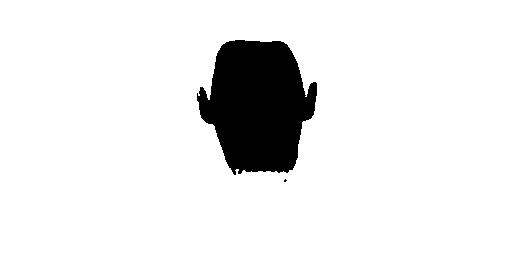

In [32]:
def invoke_endpoint(endpoint_name, payload):

    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Accept="application/json",
        ContentType="application/json",
        Body=json.dumps(payload)
    )
    data = response["Body"].read().decode("utf-8")
    return data

predictions = invoke_endpoint(endpoint_name, inputs)

mask_image = decode_image(json.loads(predictions)['mask_image'])
mask_image

In [33]:
!docker ps

CONTAINER ID   IMAGE                                                                                 COMMAND                  CREATED          STATUS          PORTS                                                 NAMES
759c066a3415   763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/pytorch-inference:2.1.0-gpu-py310   "python /usr/local/b…"   11 minutes ago   Up 10 minutes   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp, 8081/tcp   4th8ly3egt-algo-1-uoxg5


In [34]:
!docker kill 759c066a3415

759c066a3415
4th8ly3egt-algo-1-uoxg5 exited with code 137


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py", line 955, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py", line 1021, in _stream_output
    raise RuntimeError(f"Failed to run: {process.args}. Process exited with code: {exit_code}")
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmpss87_ycr/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit']. Process exited with code: 137

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/local/image.py", line 960, in run
    raise RuntimeError(msg)
RuntimeErro

In [35]:
try:
    sm_client.delete_endpoint(EndpointName=endpoint_name)
    sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    sm_client.delete_model(ModelName=sm_model_name)
except:
    print("If any docker processes are running,Retry this cell, please.")
finally:
    !docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


## 2.2. Deploy to Hosting Instance

In [36]:
instance_type='ml.g4dn.xlarge'

In [37]:
from pathlib import Path
import time

# source_dir=f"file://{Path.cwd()}/src"

if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    from sagemaker.local import entities
    # entities.HEALTH_CHECK_TIMEOUT_LIMIT=300  
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    
    model_data_url=f"file://{Path.cwd()}/model"
    model_data=f"file://{Path.cwd()}/model.tar.gz"
else:
    sagemaker_session = sagemaker.session.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data_url=s3_model_path
    
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"sam-model-{ts}"
endpoint_config_name = f"sam-endpoint-config-{ts}"
endpoint_name = f"sam-endpoint-{ts}"

In [38]:
container = {
    "Image": ecr_image_uri,
    "ModelDataSource": {
            "S3DataSource": {
                "S3Uri": model_data_url,
                "S3DataType": "S3Object",
                "CompressionType": "Gzip", ## SageMaker Hosting
            },
        },
    "Environment": {}
}

In [39]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=container
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            # "ContainerStartupHealthCheckTimeoutInSeconds": 600
        }
    ]
)

In [40]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, 
    EndpointConfigName=endpoint_config_name
)

In [41]:
sess.wait_for_endpoint(endpoint_name, poll=5)

------------------------------------------------!

{'EndpointName': 'sam-endpoint-2024-04-10-01-35-30',
 'EndpointArn': 'arn:aws:sagemaker:ap-northeast-2:533267442321:endpoint/sam-endpoint-2024-04-10-01-35-30',
 'EndpointConfigName': 'sam-endpoint-config-2024-04-10-01-35-30',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/pytorch-inference:2.1.0-gpu-py310',
     'ResolvedImage': '763104351884.dkr.ecr.ap-northeast-2.amazonaws.com/pytorch-inference@sha256:d6344a1c254a71cae1f39de2d2ec72022e42209ee487ee83dca4a2bdd11bee02',
     'ResolutionTime': datetime.datetime(2024, 4, 10, 1, 35, 58, 973000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2024, 4, 10, 1, 35, 58, 440000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 4, 10, 1, 40, 18, 723000, tzinfo=tzlocal()),
 'ResponseMet

In [42]:
%store endpoint_name img_path ecr_image_uri model_data_url

Stored 'endpoint_name' (str)
Stored 'img_path' (str)
Stored 'ecr_image_uri' (str)
Stored 'model_data_url' (str)


In [43]:
endpoint_name = 'sam-endpoint-2024-04-10-01-35-30'

In [44]:
def invoke_endpoint(endpoint_name, payload):
    smr_client = boto3.client("sagemaker-runtime")
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Accept="application/json",
        ContentType="application/json",
        Body=json.dumps(payload)
    )
    data = response["Body"].read().decode("utf-8")
    return data

## 3. Amazon Bedrock Titan Image Generation

In [45]:
modelId = "amazon.titan-image-generator-v1"
result_path = "./result"
seed = 43
cfgScale = 7.5
# height = 1152
# width = 768
resize_yn = False

In [46]:
# img_path = f'../test_images/andy_portrait_2.jpg' ## 원하는 이미지를 선택합니다.

outpaint_prompt = 'forrest'
target_label = None
# target_label = "Car"

In [47]:
%%time
ext = img_path.split('.')[-1]
if ext == 'jpg':
    ext = 'jpeg'

if target_label == None:
    object_image, width, height, f_left, f_top, f_width, f_height, human_res = show_faces(img_path) ## detect_faces
    text_prompt =  f'a human with a {outpaint_prompt} background'
else:
    object_image, width, height, f_left, f_top, f_width, f_height, color, human_res = show_labels(img_path, target_label=target_label)
    text_prompt =  f'a {target_label} with a {outpaint_prompt} and {color} background'

The detected face is between 53 and 61 years old
imgWidth : 512, imgHeight : 256
Left: 212
Top: 41
Face Width: 92
Face Height: 126
CPU times: user 342 ms, sys: 22.6 ms, total: 364 ms
Wall time: 1.43 s


In [48]:
%%time
encode_object_image = encode_image(object_image,formats=ext.upper()).decode("utf-8")
inputs = dict(
    encode_image = encode_object_image,
    input_box = [f_left, f_top, f_left+f_width, f_top+f_height]
)

predictions = invoke_endpoint(endpoint_name, inputs)
mask_image = decode_image(json.loads(predictions)['mask_image'])

CPU times: user 20.4 ms, sys: 2.11 ms, total: 22.5 ms
Wall time: 2.64 s


In [50]:
os.makedirs('./result/', exist_ok=True)
image_name = img_path.split('/')[-1]
mask_image.save(f'./result/generated_{image_name}')

## [주의] bedrock permission
AccessDeniedException: An error occurred (AccessDeniedException) when calling the InvokeModel operation: User: arn:aws:sts::533267442321:assumed-role/AmazonSageMakerServiceCatalogProductsUseRole/SageMaker is not authorized to perform: bedrock:InvokeModel on resource: arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-image-generator-v1 because no identity-based policy allows the bedrock:InvokeModel action

In [52]:
%%time
object_img = img_resize(object_image)
mask_img = img_resize(mask_image)

print(f"outpaint_prompt : {outpaint_prompt}, seed : {seed}")
# Payload creation
body = json.dumps({
    "taskType": "OUTPAINTING",
    "outPaintingParams": {
        "text": text_prompt,              # Optional
        # "negativeText": negative_prompts,    # Optional
        "image": image_to_base64(object_img),      # Required
        # "maskPrompt": mask_prompt,               # One of "maskImage" or "maskPrompt" is required
        "maskImage": image_to_base64(mask_img),  # Input maskImage based on the values 0 (black) or 255 (white) only
    },                                                 
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "quality": "premium",
        # "quality": "standard",
        "cfgScale": cfgScale,
        # "height": height,
        # "width": width,
        "seed": seed
    }
})

# Model invocation
boto3_bedrock = boto3_runtime(
    service_name='bedrock-runtime',
    target_region="us-west-2"
)

response = boto3_bedrock.invoke_model(
    body=body,
    modelId=modelId,
    accept="application/json", 
    contentType="application/json"
)

# Output processing
response_body = json.loads(response.get("body").read())
img_b64 = response_body["images"][0]
print(f"Output: {img_b64[0:80]}...")

# Decode + save
img_result = Image.open(
    BytesIO(
        base64.decodebytes(
            bytes(img_b64, "utf-8")
        )
    )
)
if resize_yn:
    img_result = img_result.resize((360, 480), 0)
output_path = result_path + '/generated_'+img_path.split('/')[-1]
os.makedirs(result_path, exist_ok=True)
img_result.save(output_path)
print(f"Gnerating an image in {output_path}")

outpaint_prompt : forrest, seed : 43
Output: iVBORw0KGgoAAAANSUhEUgAAAgAAAAEACAIAAABK8lkwAAEAAElEQVR4nCz519OmeX7eh31/+c5Pft73...
Gnerating an image in ./result/generated_andy_portrait_2.jpg
CPU times: user 92.2 ms, sys: 15.4 ms, total: 108 ms
Wall time: 11.5 s


Text(0.5, 0.98, 'Image comparison')

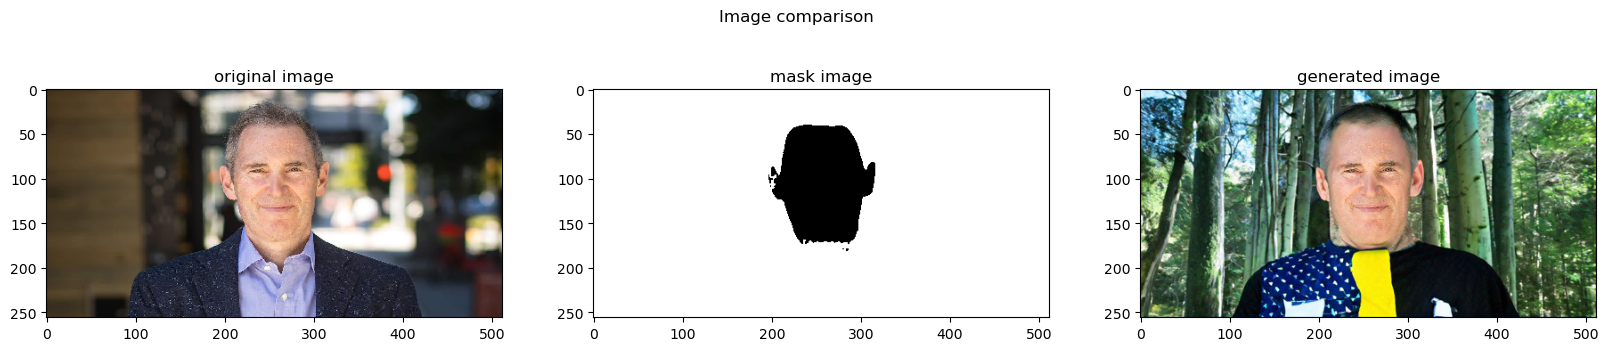

In [53]:
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.imshow(object_image)
plt.title('original image')

plt.subplot(1, 3, 2)
plt.imshow(mask_image)
plt.title('mask image')

plt.subplot(1, 3, 3)
plt.imshow(img_result)
plt.title('generated image')

plt.suptitle('Image comparison')

In [54]:
%%time
prompt = f"이미지에 대해 한국어로 설명을 해줘"
prompt_config = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 4096,
    "temperature" : 0,
    "top_k": 350,
    "top_p": 0.999,
    "messages": [
        {
            "role": "user", "content": [
                {"type": "image", "source": {"type": "base64", "media_type": f"image/{ext}", "data": image_to_base64(object_image)}},
                {"type": "text", "text": prompt},
            ],
        }
    ],
}


body_text = json.dumps(prompt_config)

modelId_text = 'anthropic.claude-3-sonnet-20240229-v1:0'
response_text = boto3_bedrock.invoke_model(
    body=body_text,
    modelId=modelId_text,
    accept="application/json", 
    contentType="application/json"
)

import json
response_text_body = json.loads(response_text.get("body").read())
results = response_text_body.get("content")[0].get("text")

results

CPU times: user 36.3 ms, sys: 0 ns, total: 36.3 ms
Wall time: 4.57 s


'이 이미지는 웃고 있는 중년 남성의 상반신 사진입니다. 그는 회색 머리카락과 주름진 얼굴을 가지고 있습니다. 그는 보라색 셔츠와 검은색 스웨터 재킷을 입고 있습니다. 배경은 도시 거리의 모습으로 보이며 차량과 간판들이 보입니다. 그의 표정은 밝고 행복해 보입니다.'

## Delete resource

In [ ]:
# try:
#     sm_client.delete_endpoint(EndpointName=endpoint_name)
#     sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
#     sm_client.delete_model(ModelName=sm_model_name)
# except:
#     print("If any docker processes are running,Retry this cell, please.")